# Light curve parameterization notes

I played around quite a bit with different ways to parameterize the light curve. Here are four fits based to the same light curve using the following different bases"

1. $\{b, R_p/R_\star, \log{\rho_{\star,circ}} \}$
2. $\{b, R_p/R_\star, \log{D} \}$, where $D$ is the duration of the transit ingress midpoint to egress midpoint
3. $\{b, R_p/R_\star, \log{T_{14}} \}$
4. $\{b,  y, \log{T_{14}} \}$, where $y = (R_p/R_\star / \sqrt{d} - 1) \sqrt{1 - b^2}$ and d is the depth of the transit

I found that Basis 4 performed the best. More draws per second with a lower divergence rate. 

When using Basis 1 there is a strong curving degeneracy between all three parameters. When swapping out $\log{\rho_{\star,circ}}$ for $\log{D}$ (Basis 2), there is much less degeneracy between $\log{D}-R_p/R_\star$ and $\log{D}-b$. However, divergences seem to be a problem perhaps there is a funnel at high impact parameter that's screwing things up. Swapping out $\log{\rho_{\star,circ}}$ for $\log{T_{14}}$ the convergence properies seemed to improve. But still, there is a strong curving degeneracy between $Rp/Rstar$ and $b$, due to the trade off between impact parameter and the stellar surface brightness along the transit chord. It seemed silly to force the pymc3 sampler to "rediscover" this relationship which is a quadratic function of $\mu$ = $\cos \theta$ = $\sqrt{1 - s^2}$, where $s$ is instantaneous planet planet to star separation in units of $R_\star$. So by sampling in $y$ the NUTS sampler only has to sample a quadratic relationship, as opposed to the strongly curving trig relationship. Dividing by the square root of the measured transit depth "standardizes" the data. 

## Imports and defining some functions 

In [1]:
%pylab inline
%load_ext line_profiler
import scipy
import exoplanet as xo
import arviz
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from numpy.random import normal, multivariate_normal
from chainconsumer import ChainConsumer
import seaborn as sns
from scipy import stats
rcParams['figure.dpi'] = 160
def _tfold(t, per, tc):
    return np.mod(((t - tc) + 0.5 * per),per) -  0.5 * per

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.dpi'] = 160

## Generating a synthetic light curve

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


snr 45.41952590388118


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


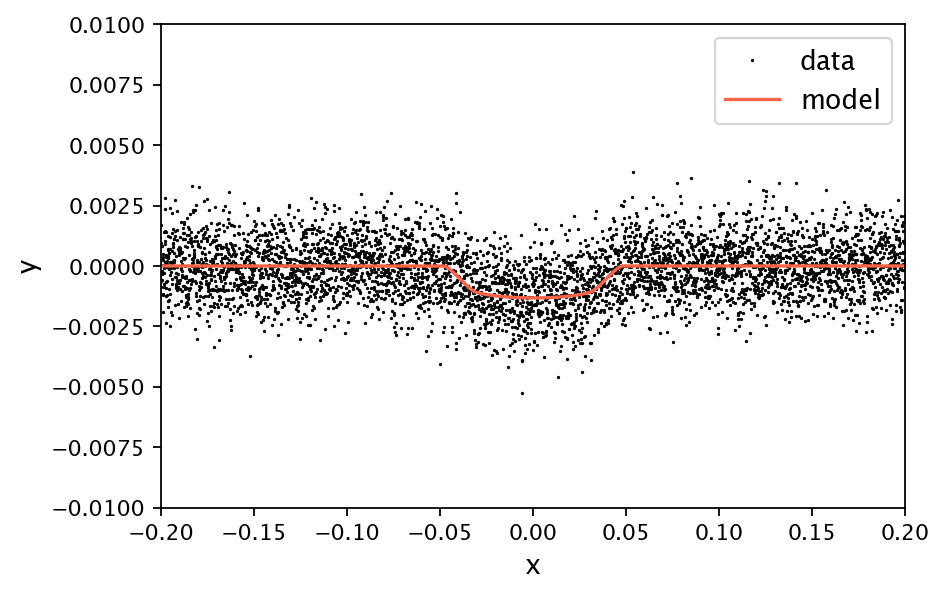

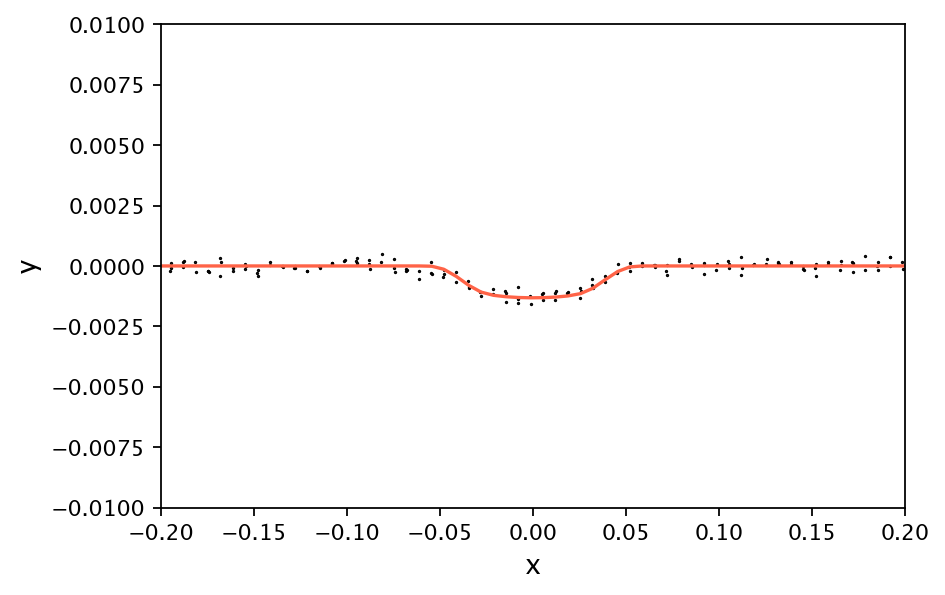

In [3]:
np.random.seed(42)
truth = dict(per=10.3134134, tc=5.124124, b=0.9, r=0.04, ecc=0.0, omega=90)
u = np.array([0.4451, 0.2297])
texp_lc = 0.02
texp_sc = texp_lc/30
yerr_lc = 2e-4
yerr_sc = yerr_lc*sqrt(texp_lc/texp_sc)
t = np.arange(0, 80, texp_sc)
orbit0 = xo.orbits.KeplerianOrbit(
    period=truth['per'], 
    t0=truth['tc'], 
    b=truth['b'], 
    ecc=truth['ecc'],
    omega=truth['omega'],
    rho_star = 1
)

lc_model = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit0, r=truth['r'], t=t,texp=None).eval()
lc_data = (lc_model + yerr_sc * np.random.randn(*lc_model.shape)).reshape(-1) # need this for single planet fit
tfold = _tfold(t, truth['per'],truth['tc'])
isort = argsort(tfold)

plt.plot(tfold[isort], lc_data[isort],'.',ms=1,color="k", label="data")
plt.plot(tfold[isort], lc_model[isort], "C1", label="model")
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.01, 0.01);


# Create long cadence light curve
figure()
lc_data_lc = lc_data.reshape(-1,30).mean(axis=1)
lc_model_lc = lc_model.reshape(-1,30).mean(axis=1)
t_lc = t.reshape(-1,30).mean(axis=1)
tfold_lc = _tfold(t_lc, truth['per'],truth['tc'])
isort_lc = argsort(tfold_lc)


plt.plot(tfold_lc[isort_lc], lc_data_lc[isort_lc],'.',ms=1,color="k", label="data")
plt.plot(tfold_lc[isort_lc], lc_model_lc[isort_lc], "C1", label="model")

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.01, 0.01);


print("snr {}".format(truth['r']**2 / yerr_sc * sqrt(len(orbit0.in_transit(t).eval()))))

## Basis 1: $\{b, R_p/R_\star, \log{\rho_{\star,circ}} \}$

In [4]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_lc:
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    r = pm.Uniform("r", lower=0.00, upper=0.1, testval=0.05)
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.5)
    logrho = pm.Uniform("logrho", lower=-2, upper=2, testval=0)
    rho = pm.Deterministic("rho", 10**logrho)
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=lc_data_lc)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)

print(map_soln)

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
62it [00:00, 244.73it/s, logp=2.821920e+04]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/ten

{'mean': array(1.87331788e-06), 'r_interval__': array(-0.65684177), 'b_impact__': array(0.62520681), 'logrho_interval__': array(0.67984421), 'r': array(0.03414494), 'b': array(0.67364391), 'logrho': array(0.6548157), 'rho': array(4.51664234)}


In [5]:
tune=1000
draws=2000
target_accept=0.95
doubling=False
with model_lc:
    tr_lc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logrho, b, r, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [06:51<00:00, 29.16draws/s]
The acceptance probability does not match the target. It is 0.9056425822032591, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8585184166651669, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% f

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
mean    0.000  0.000     0.000   -0.000     0.000  3895.836  1.000
r       0.035  0.004     0.000    0.031     0.043   412.544  1.012
b       0.596  0.297     0.012    0.063     0.971   541.375  1.005
logrho  0.512  0.504     0.020   -0.410     1.110   472.809  1.009
rho     5.306  4.010     0.150    0.222    11.625   594.155  1.004


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


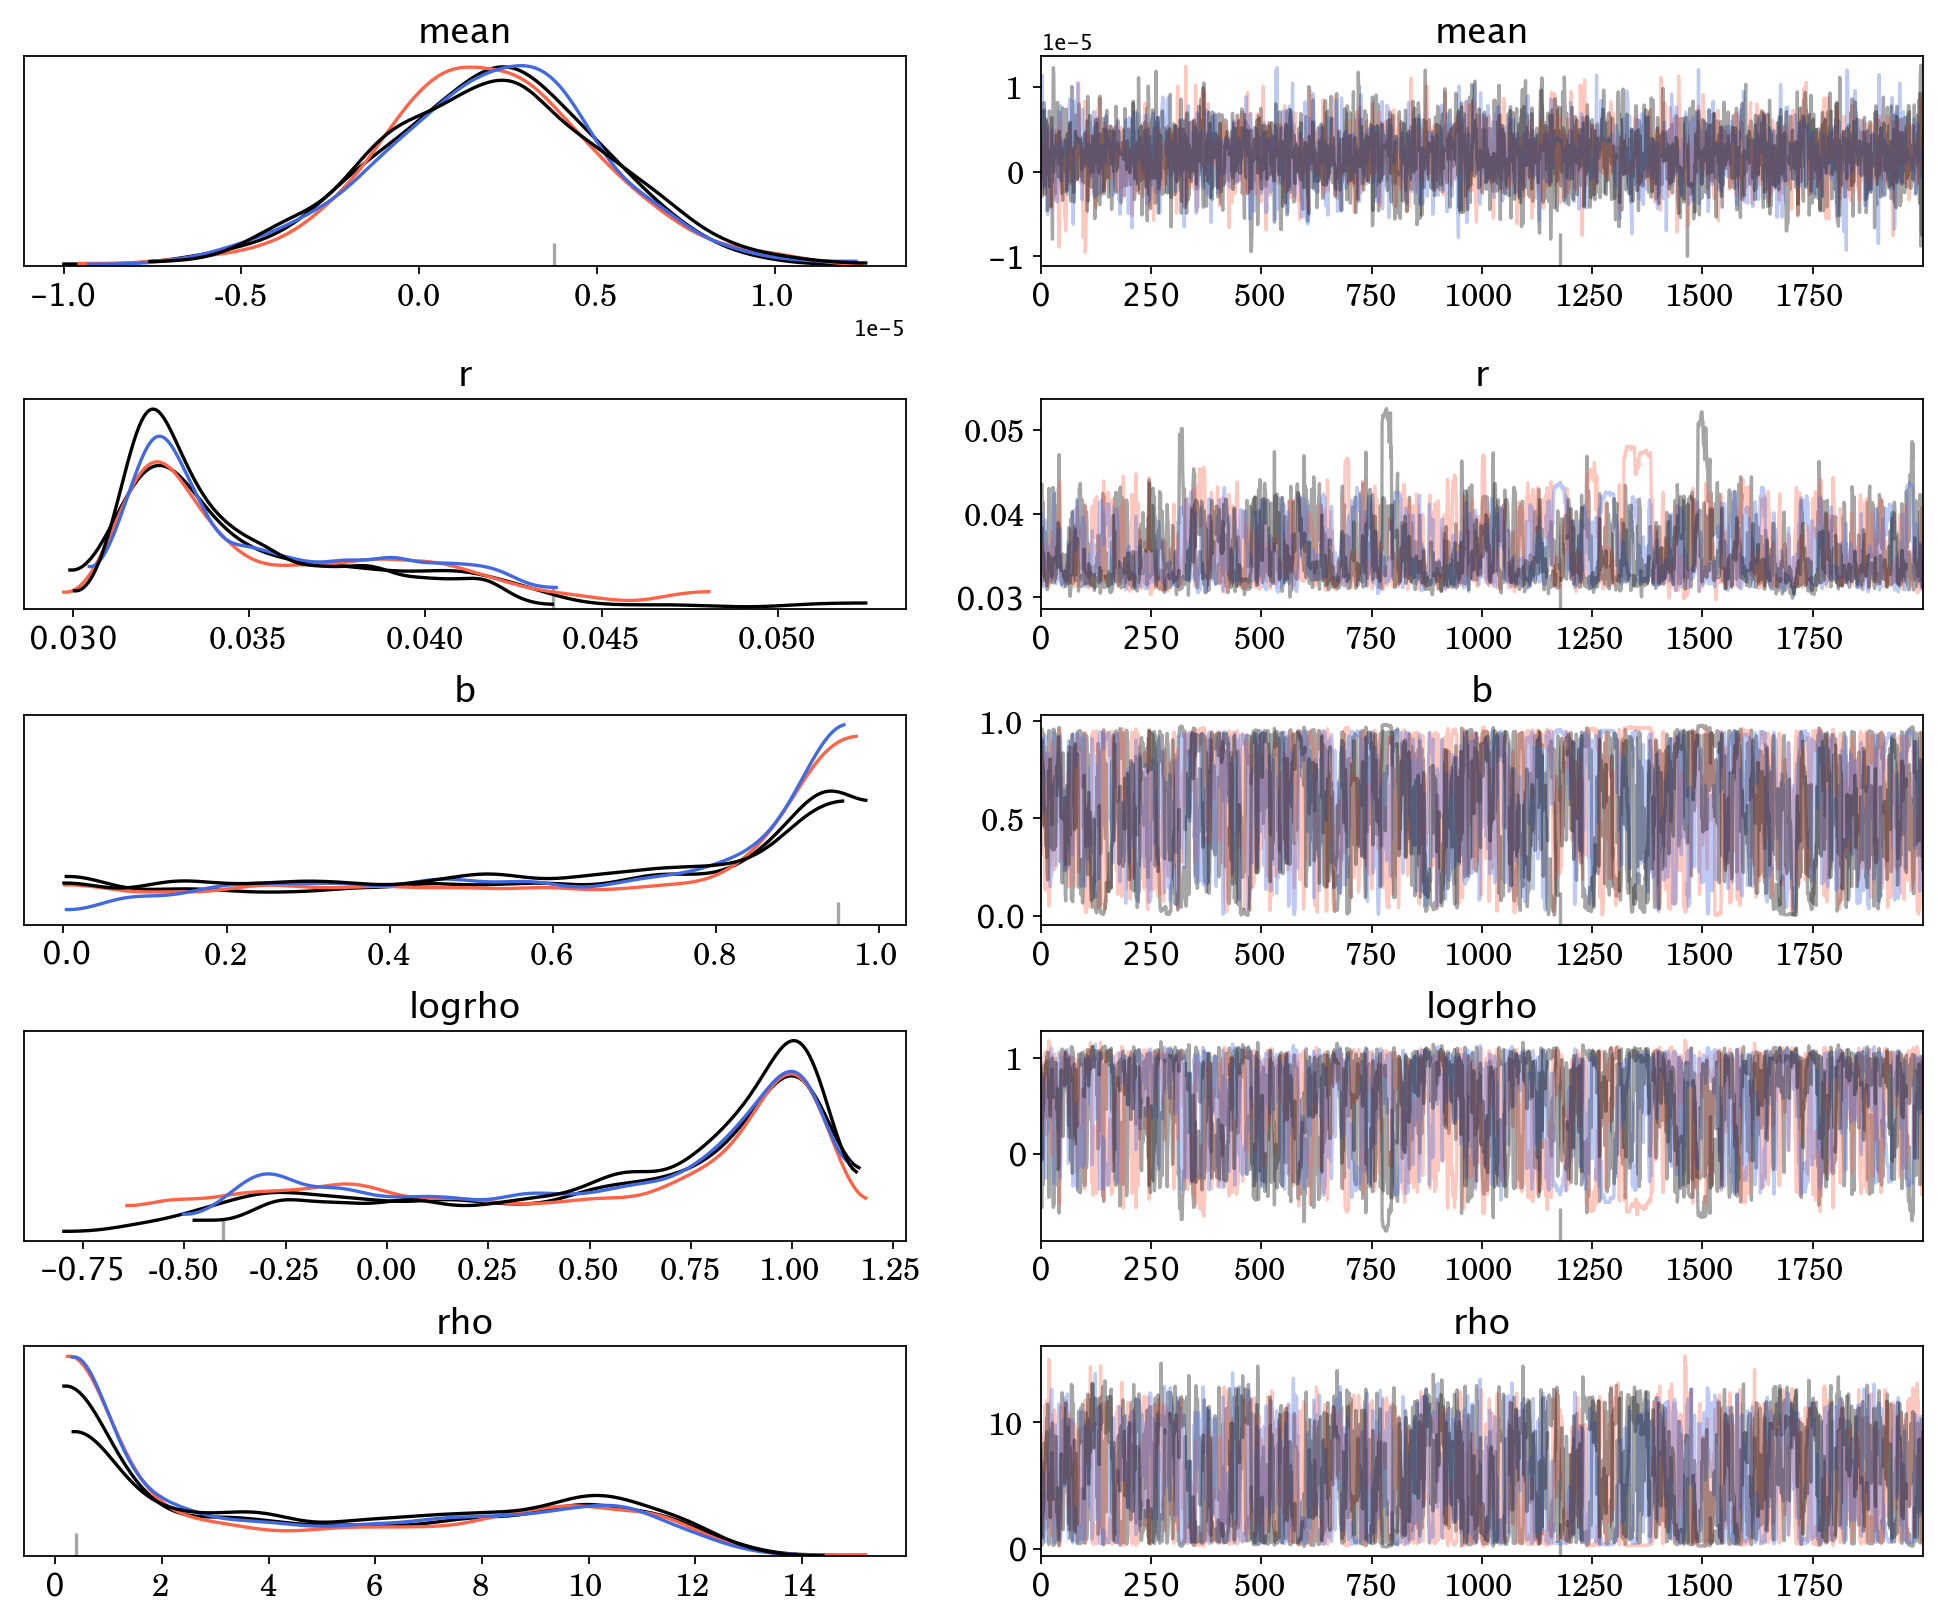

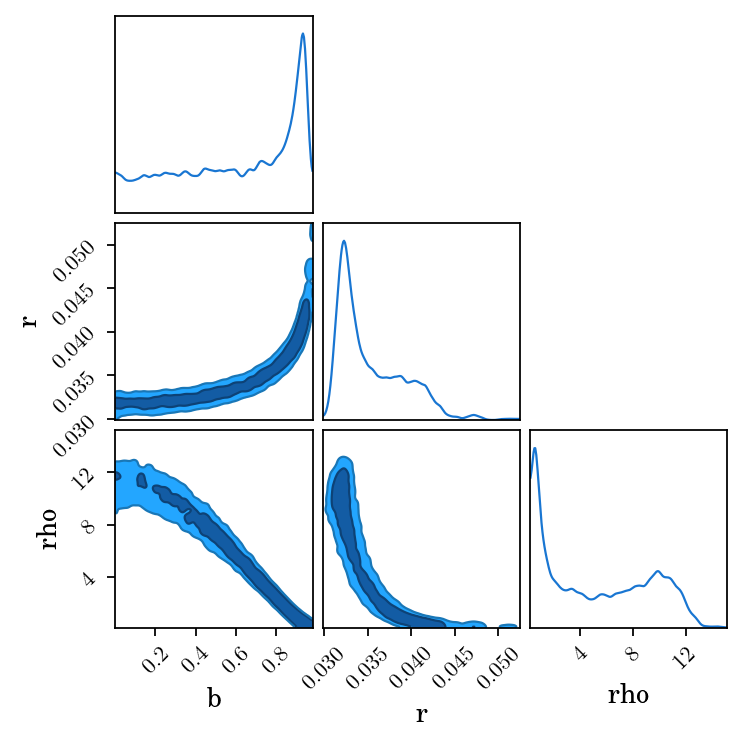

In [6]:
df = pm.trace_to_dataframe(tr_lc)
df.to_csv('chain_notes_param-b-rp-rho_95.csv')
print( pm.summary(tr_lc).round(3) ) 
pm.traceplot(tr_lc)
df = pm.trace_to_dataframe(tr_lc)
varnames='b r rho'.split()
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(-0.002, 0.001)

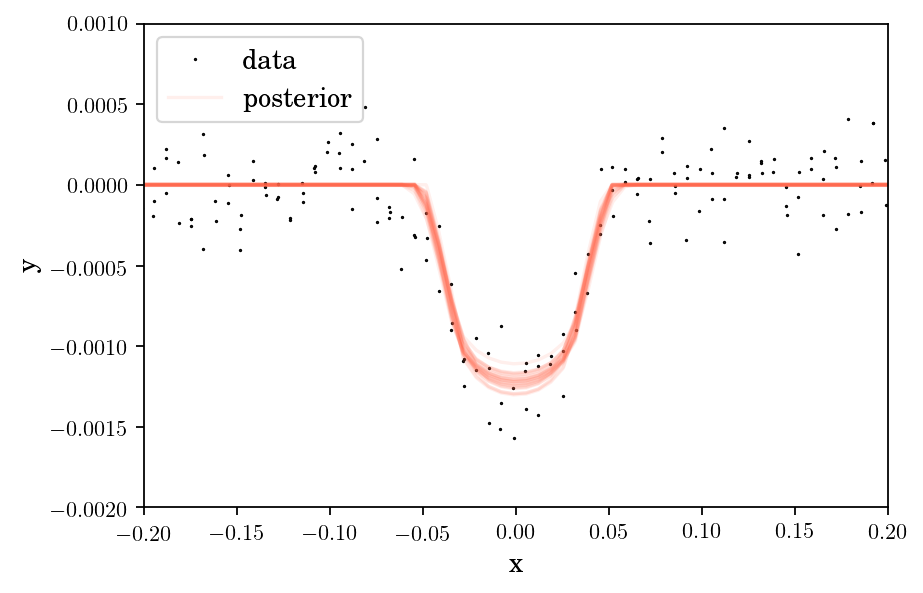

In [7]:
tfold = _tfold(t_lc, truth['per'],truth['tc'])
x_grid = t_lc
nsamples= 25
samples = np.empty((nsamples, len(x_grid)))
with model_lc:
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    y_grid = light_curve
    for i, sample in enumerate(xo.get_samples_from_trace(tr_lc, size=nsamples)):
        samples[i] = xo.eval_in_model(y_grid, sample)
        
isort = argsort(tfold_lc)
plt.plot(tfold_lc[isort], lc_data_lc[isort], ".k",ms=1, label="data")
plt.plot(tfold_lc[isort], samples[0,isort],color="C1", alpha=0.1, label="posterior")
plt.plot(tfold_lc[isort], samples[1:,isort].T,color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.002,0.001)

## Basis 2: $\{b, R_p/R_\star, \log{D} \}$

In [8]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_lc:
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    r = pm.Uniform("r", lower=0.00, upper=0.1, testval=0.05)
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.5)
    logdur = pm.Uniform("logdur", lower=-2, upper=0, testval=-1) # duration in log days
    dur = pm.Deterministic("dur", 10**logdur)
    rho = pm.Deterministic("rho", (3 / np.pi**2 / grav) * truth['per'] / dur**3 * tt.sqrt((1 - b**2)**3))
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=lc_data_lc)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)
    
print(map_soln)

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
10it [00:00, 58.42it/s, logp=2.834308e+04]
message: Optimization terminated successfully.
logp: 27148.826950079652 -> 2

{'mean': array(1.86428714e-06), 'r_interval__': array(-0.68366662), 'b_impact__': array(0.34327222), 'logdur_interval__': array(-0.16746742), 'r': array(0.03354434), 'b': array(0.60460811), 'logdur': array(-1.08353856), 'dur': array(0.08250142), 'rho': array(5.66259951)}


In [9]:
tune=1000
draws=2000
target_accept=0.95
doubling=False
with model_lc:
    tr_lc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logdur, b, r, mean]
INFO:pymc3:NUTS: [logdur, b, r, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:50<00:00, 70.43draws/s] 
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8762543443389585, but should be close to 0.95. Try to increase the number of tuning steps.
There were 54 

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
mean    0.000  0.000     0.000   -0.000     0.000  1298.637  1.002
r       0.036  0.004     0.000    0.031     0.044   132.473  1.000
b       0.606  0.306     0.013    0.067     0.966   417.389  1.002
logdur -1.087  0.016     0.001   -1.123    -1.058   277.788  1.004
dur     0.082  0.003     0.000    0.075     0.087   296.958  1.004
rho     5.147  4.119     0.171    0.232    11.693   409.976  1.001


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


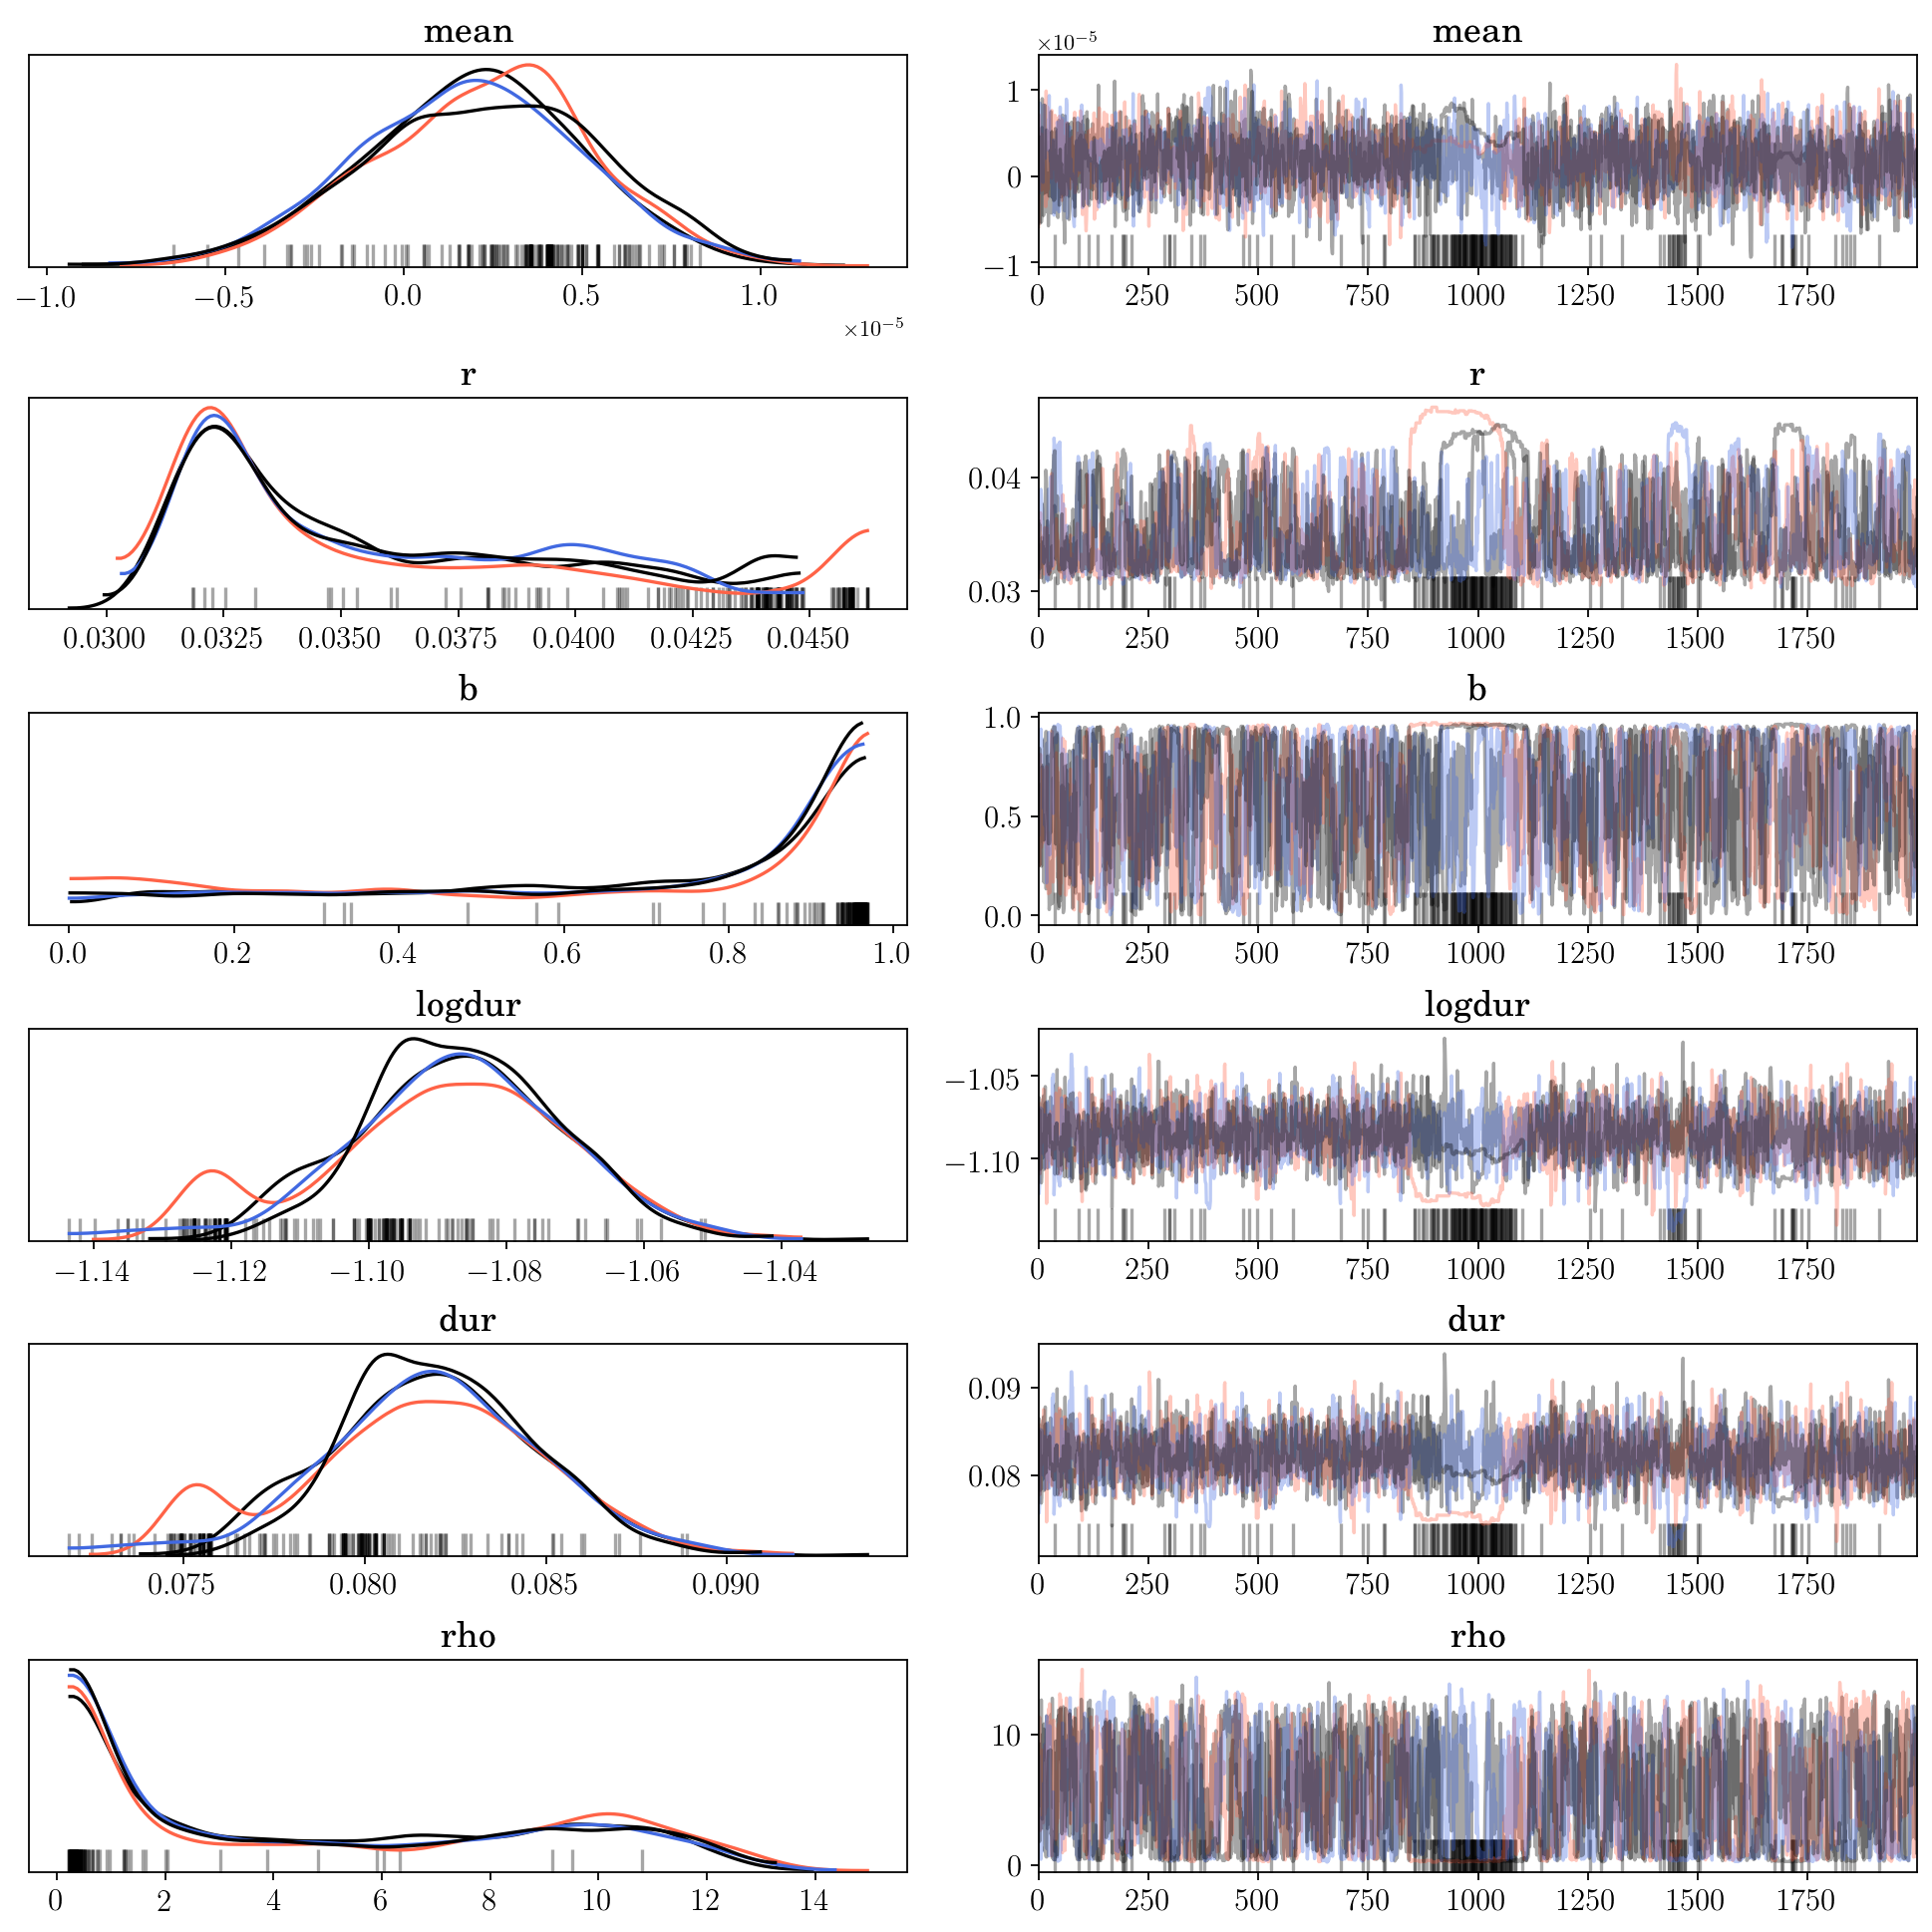

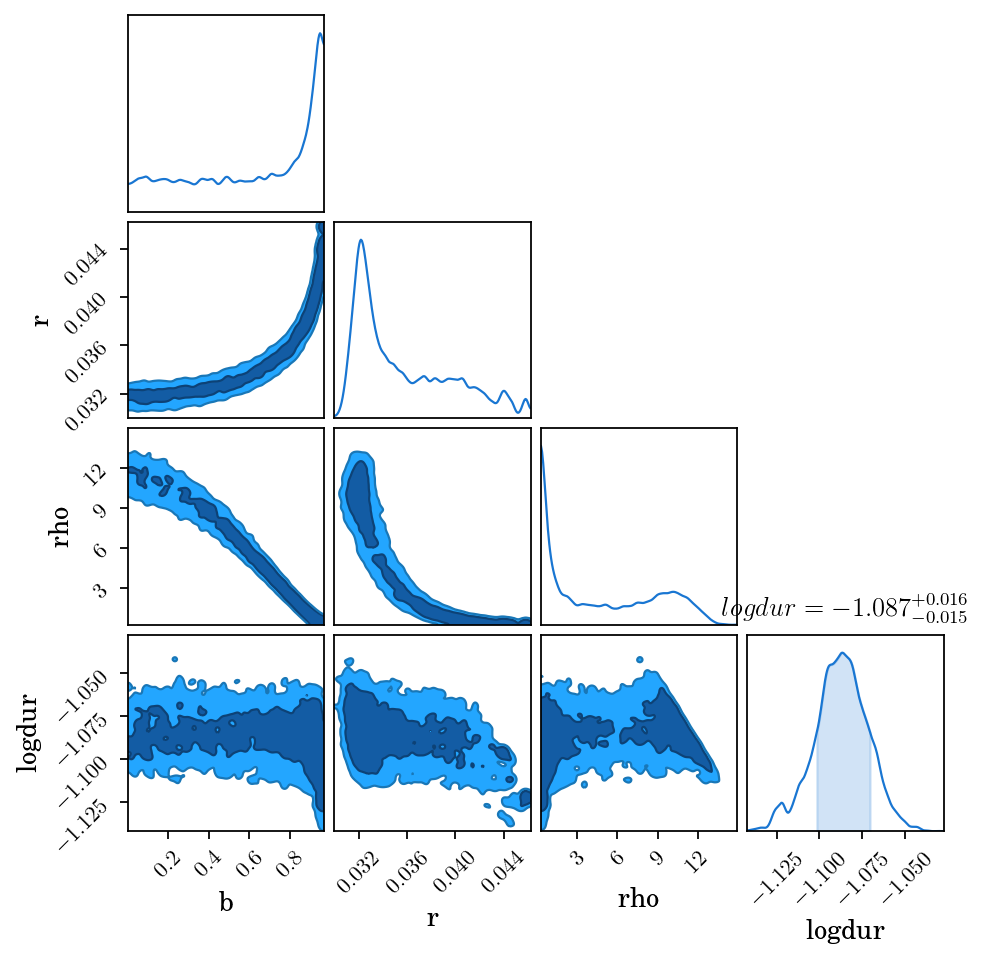

In [10]:
df = pm.trace_to_dataframe(tr_lc)
df.to_csv('chain_notes_param-b-rp-logdur_95.csv')
print( pm.summary(tr_lc).round(3) ) 
pm.traceplot(tr_lc)
df = pm.trace_to_dataframe(tr_lc)
varnames='b r rho logdur'.split()
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(-0.002, 0.001)

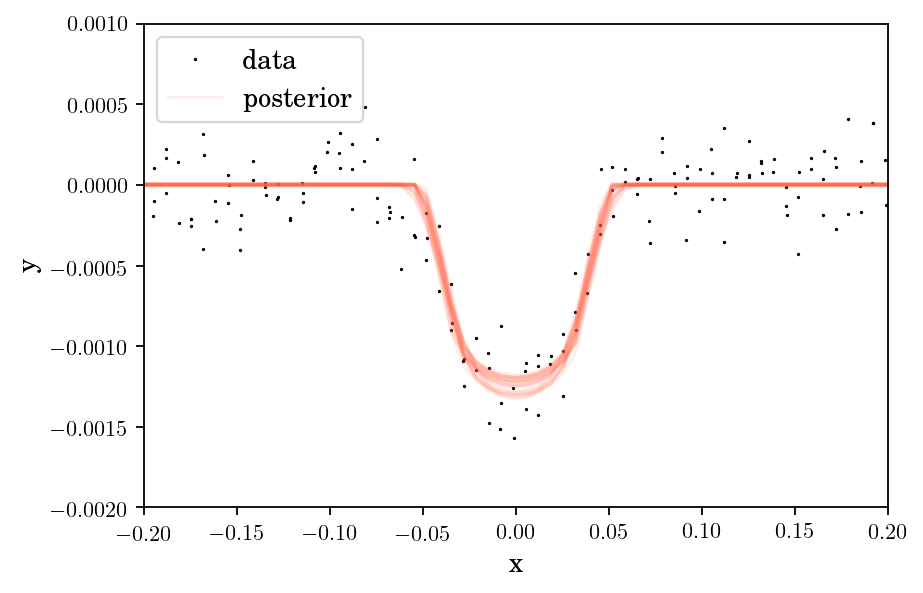

In [11]:
tfold = _tfold(t_lc, truth['per'],truth['tc'])
x_grid = t_lc
nsamples= 25
samples = np.empty((nsamples, len(x_grid)))
with model_lc:
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    y_grid = light_curve
    for i, sample in enumerate(xo.get_samples_from_trace(tr_lc, size=nsamples)):
        samples[i] = xo.eval_in_model(y_grid, sample)
        
isort = argsort(tfold_lc)
plt.plot(tfold_lc[isort], lc_data_lc[isort], ".k",ms=1, label="data")
plt.plot(tfold_lc[isort], samples[0,isort],color="C1", alpha=0.1, label="posterior")
plt.plot(tfold_lc[isort], samples[1:,isort].T,color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.002,0.001)

## Basis 3: $\{b, R_p/R_\star, \log{T_{14}} \}$

In [12]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_lc:
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    r = pm.Uniform("r", lower=0.00, upper=0.1, testval=0.05)
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.5)
    logT14 = pm.Uniform("logT14", lower=-2, upper=0, testval=-1) # duration in log days
    T14 = pm.Deterministic("T14", 10**logT14)
    a = truth['per'] / pi * tt.sqrt( (1+r)**2 - b**2 ) / T14
    rho = pm.Deterministic("rho", 3 * np.pi / grav / truth['per']**2 * a**3)
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=lc_data_lc)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)
    
print(map_soln)

optimizing logp for variables: [r]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
10it [00:00, 36.05it/s, logp=2.834996e+04]
message: Optimization terminated successfully.
logp: 27295.830564025342 -> 28349.957695324483
optimizing logp for variables: [logT14, b, r, mean]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will resu

{'mean': array(1.86430605e-06), 'r_interval__': array(-0.68346045), 'b_impact__': array(0.34560983), 'logT14_interval__': array(-0.1228346), 'r': array(0.03354894), 'b': array(0.60519724), 'logT14': array(-1.06134019), 'T14': array(0.086828), 'rho': array(5.65319429)}



message: Desired error not necessarily achieved due to precision loss.
logp: 28349.957695324483 -> 28360.765535230148


In [13]:
tune=1000
draws=2000
target_accept=0.95
doubling=False
with model_lc:
    tr_lc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logT14, b, r, mean]
INFO:pymc3:NUTS: [logT14, b, r, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [04:22<00:00, 45.77draws/s]
The acceptance probability does not match the target. It is 0.8588294337751277, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
mean    0.000  0.000     0.000   -0.000     0.000  2688.182  1.000
r       0.035  0.004     0.000    0.031     0.042   463.908  1.011
b       0.590  0.290     0.011    0.079     0.966   792.919  1.002
logT14 -1.045  0.035     0.001   -1.094    -0.965   570.482  1.012
T14     0.091  0.008     0.000    0.080     0.107   544.010  1.013
rho     5.439  3.947     0.139    0.237    11.655   814.871  1.002


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


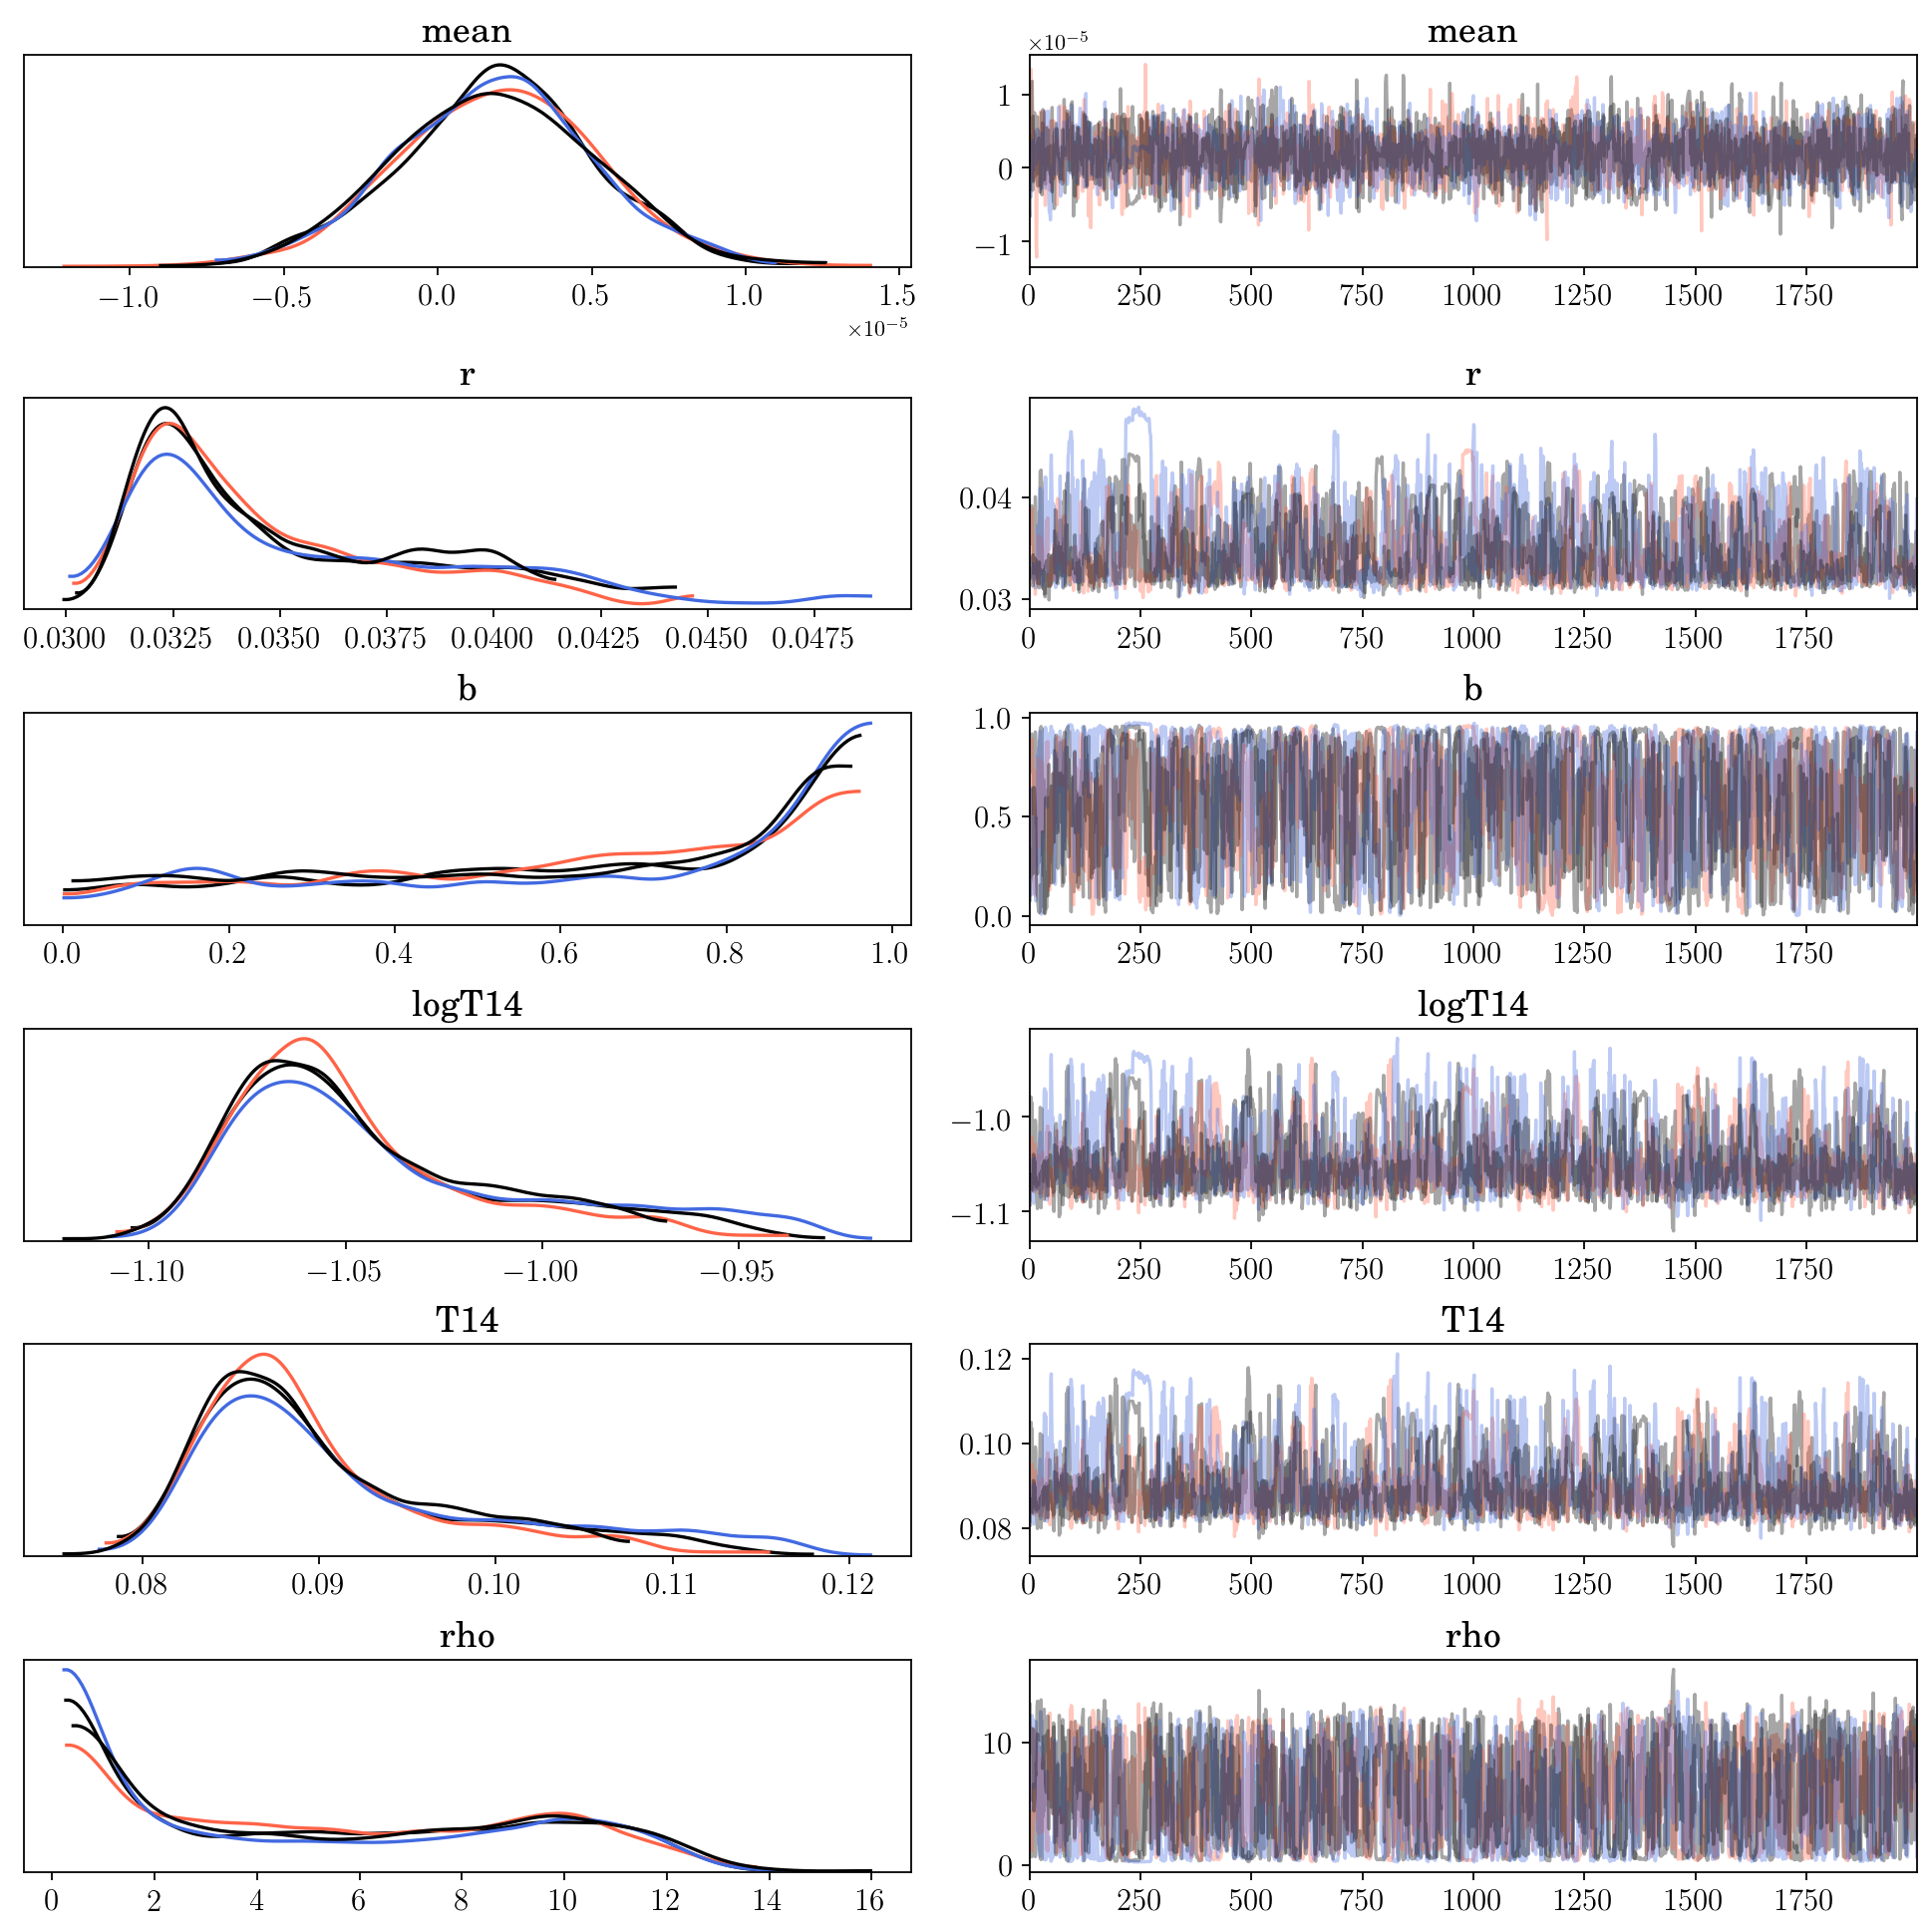

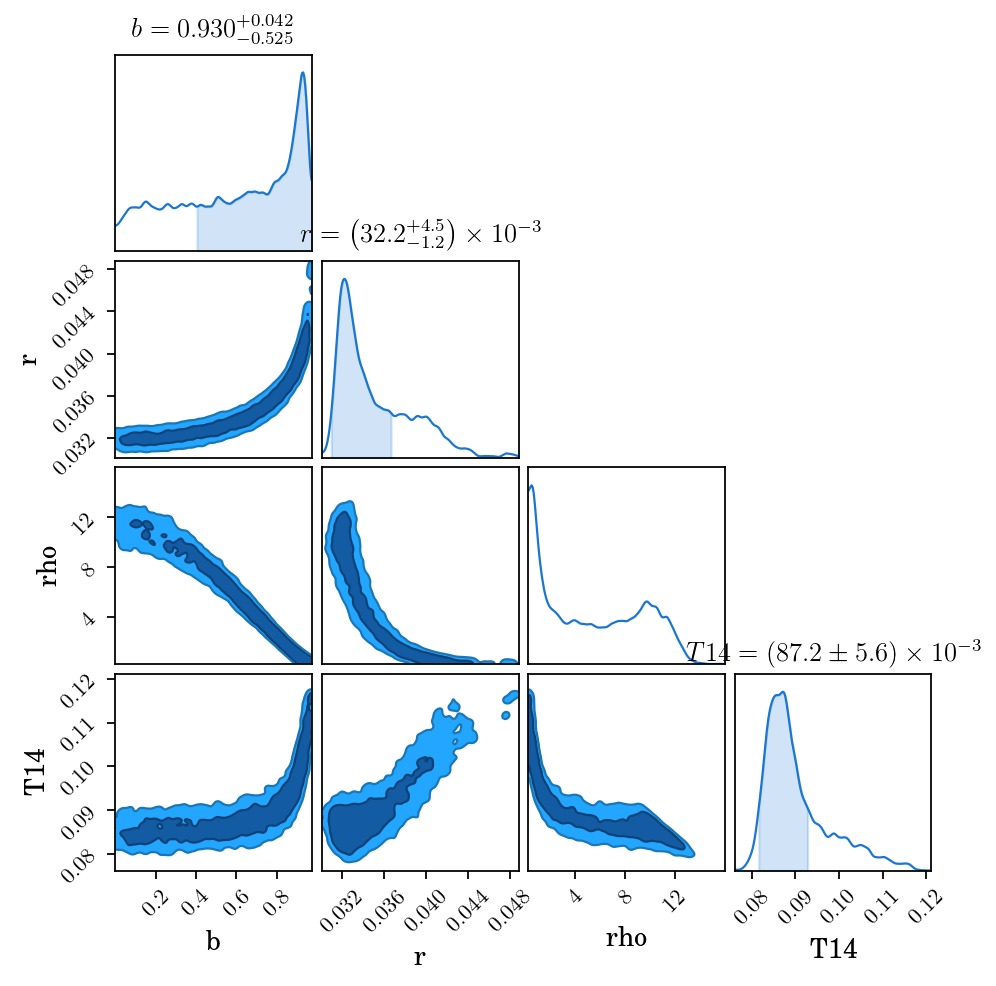

In [14]:
df = pm.trace_to_dataframe(tr_lc)
df.to_csv('chain_notes_param-b-rp-logT14_95.csv')
print( pm.summary(tr_lc).round(3) ) 
pm.traceplot(tr_lc)
df = pm.trace_to_dataframe(tr_lc)
varnames='b r rho T14'.split()
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(-0.002, 0.001)

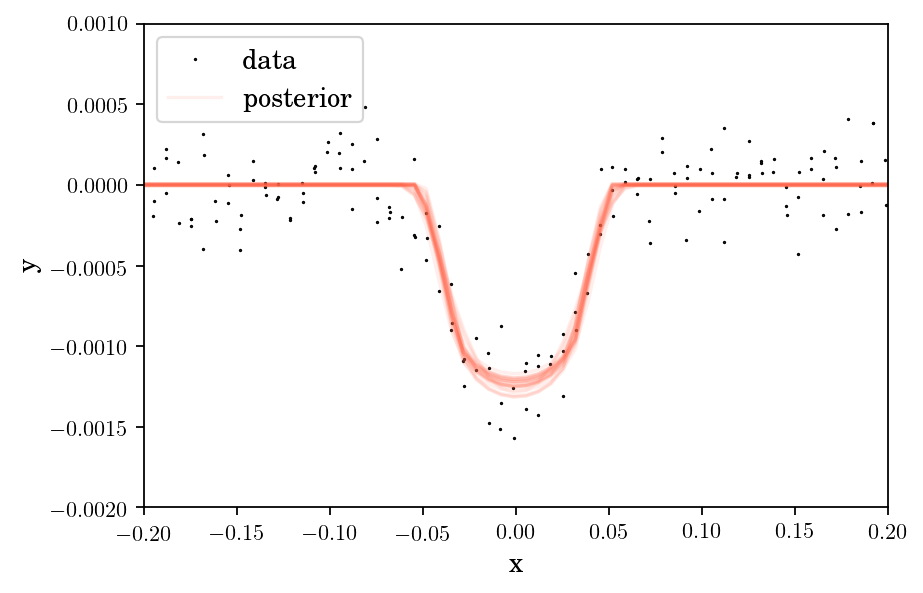

In [15]:
tfold = _tfold(t_lc, truth['per'],truth['tc'])
x_grid = t_lc
nsamples= 25
samples = np.empty((nsamples, len(x_grid)))
with model_lc:
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    y_grid = light_curve
    for i, sample in enumerate(xo.get_samples_from_trace(tr_lc, size=nsamples)):
        samples[i] = xo.eval_in_model(y_grid, sample)
        
isort = argsort(tfold_lc)
plt.plot(tfold_lc[isort], lc_data_lc[isort], ".k",ms=1, label="data")
plt.plot(tfold_lc[isort], samples[0,isort],color="C1", alpha=0.1, label="posterior")
plt.plot(tfold_lc[isort], samples[1:,isort].T,color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.002,0.001)

## Basis 4 $\{b,  y, \log{T_{14}} \}$

In [16]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_lc:
    # Setup light curve
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    b = pm.Uniform("b", lower=0.0,upper=1.0)
    y = pm.Uniform("y", lower=-1, upper=1, testval=0.05)
    r = pm.Deterministic("r", 0.032* (y / tt.sqrt(1-b**2) + 1  )  )
    logT14 = pm.Uniform("logT14", lower=-2, upper=0, testval=-1) # duration in log days
    T14 = pm.Deterministic("T14", 10**logT14)
    a = truth['per'] / pi * tt.sqrt( (1+r)**2 - b**2 ) / T14
    rho = pm.Deterministic("rho", 3 * np.pi / grav / truth['per']**2 * a**3)
    
    # Compute light curve
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, a=a)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Compute likelihood
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=lc_data_lc)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)
    
print(map_soln)

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [y, b]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
25it [00:00, 53.21it/s, logp=2.836054e+04] 
message: Optimization terminated successfully.
logp: 28338.738678509166 

{'mean': array(1.99931869e-06), 'b_interval__': array(2.50837893), 'y_interval__': array(0.19572847), 'logT14_interval__': array(0.0136158), 'b': array(0.92472713), 'y': array(0.097553), 'r': array(0.04020138), 'logT14': array(-0.99319221), 'T14': array(0.1015799), 'rho': array(0.64882788)}


In [17]:
tune=1000
draws=2000
target_accept=0.95
doubling=False
with model_lc:
    tr_lc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logT14, y, b, mean]
INFO:pymc3:NUTS: [logT14, y, b, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:01<00:00, 99.01draws/s] 
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 29 divergences after tuning. Increase `target_accept` or repar

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
mean    0.000  0.000     0.000   -0.000     0.000  4089.496  1.001
b       0.501  0.295     0.010    0.029     0.958   921.027  1.003
y       0.035  0.041     0.001   -0.032     0.109   991.193  1.003
r       0.034  0.004     0.000    0.031     0.042   874.835  1.004
logT14 -1.051  0.034     0.001   -1.096    -0.967   911.995  1.003
T14     0.089  0.007     0.000    0.079     0.107   888.668  1.004
rho     6.591  3.887     0.124    0.212    11.894   984.485  1.003


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


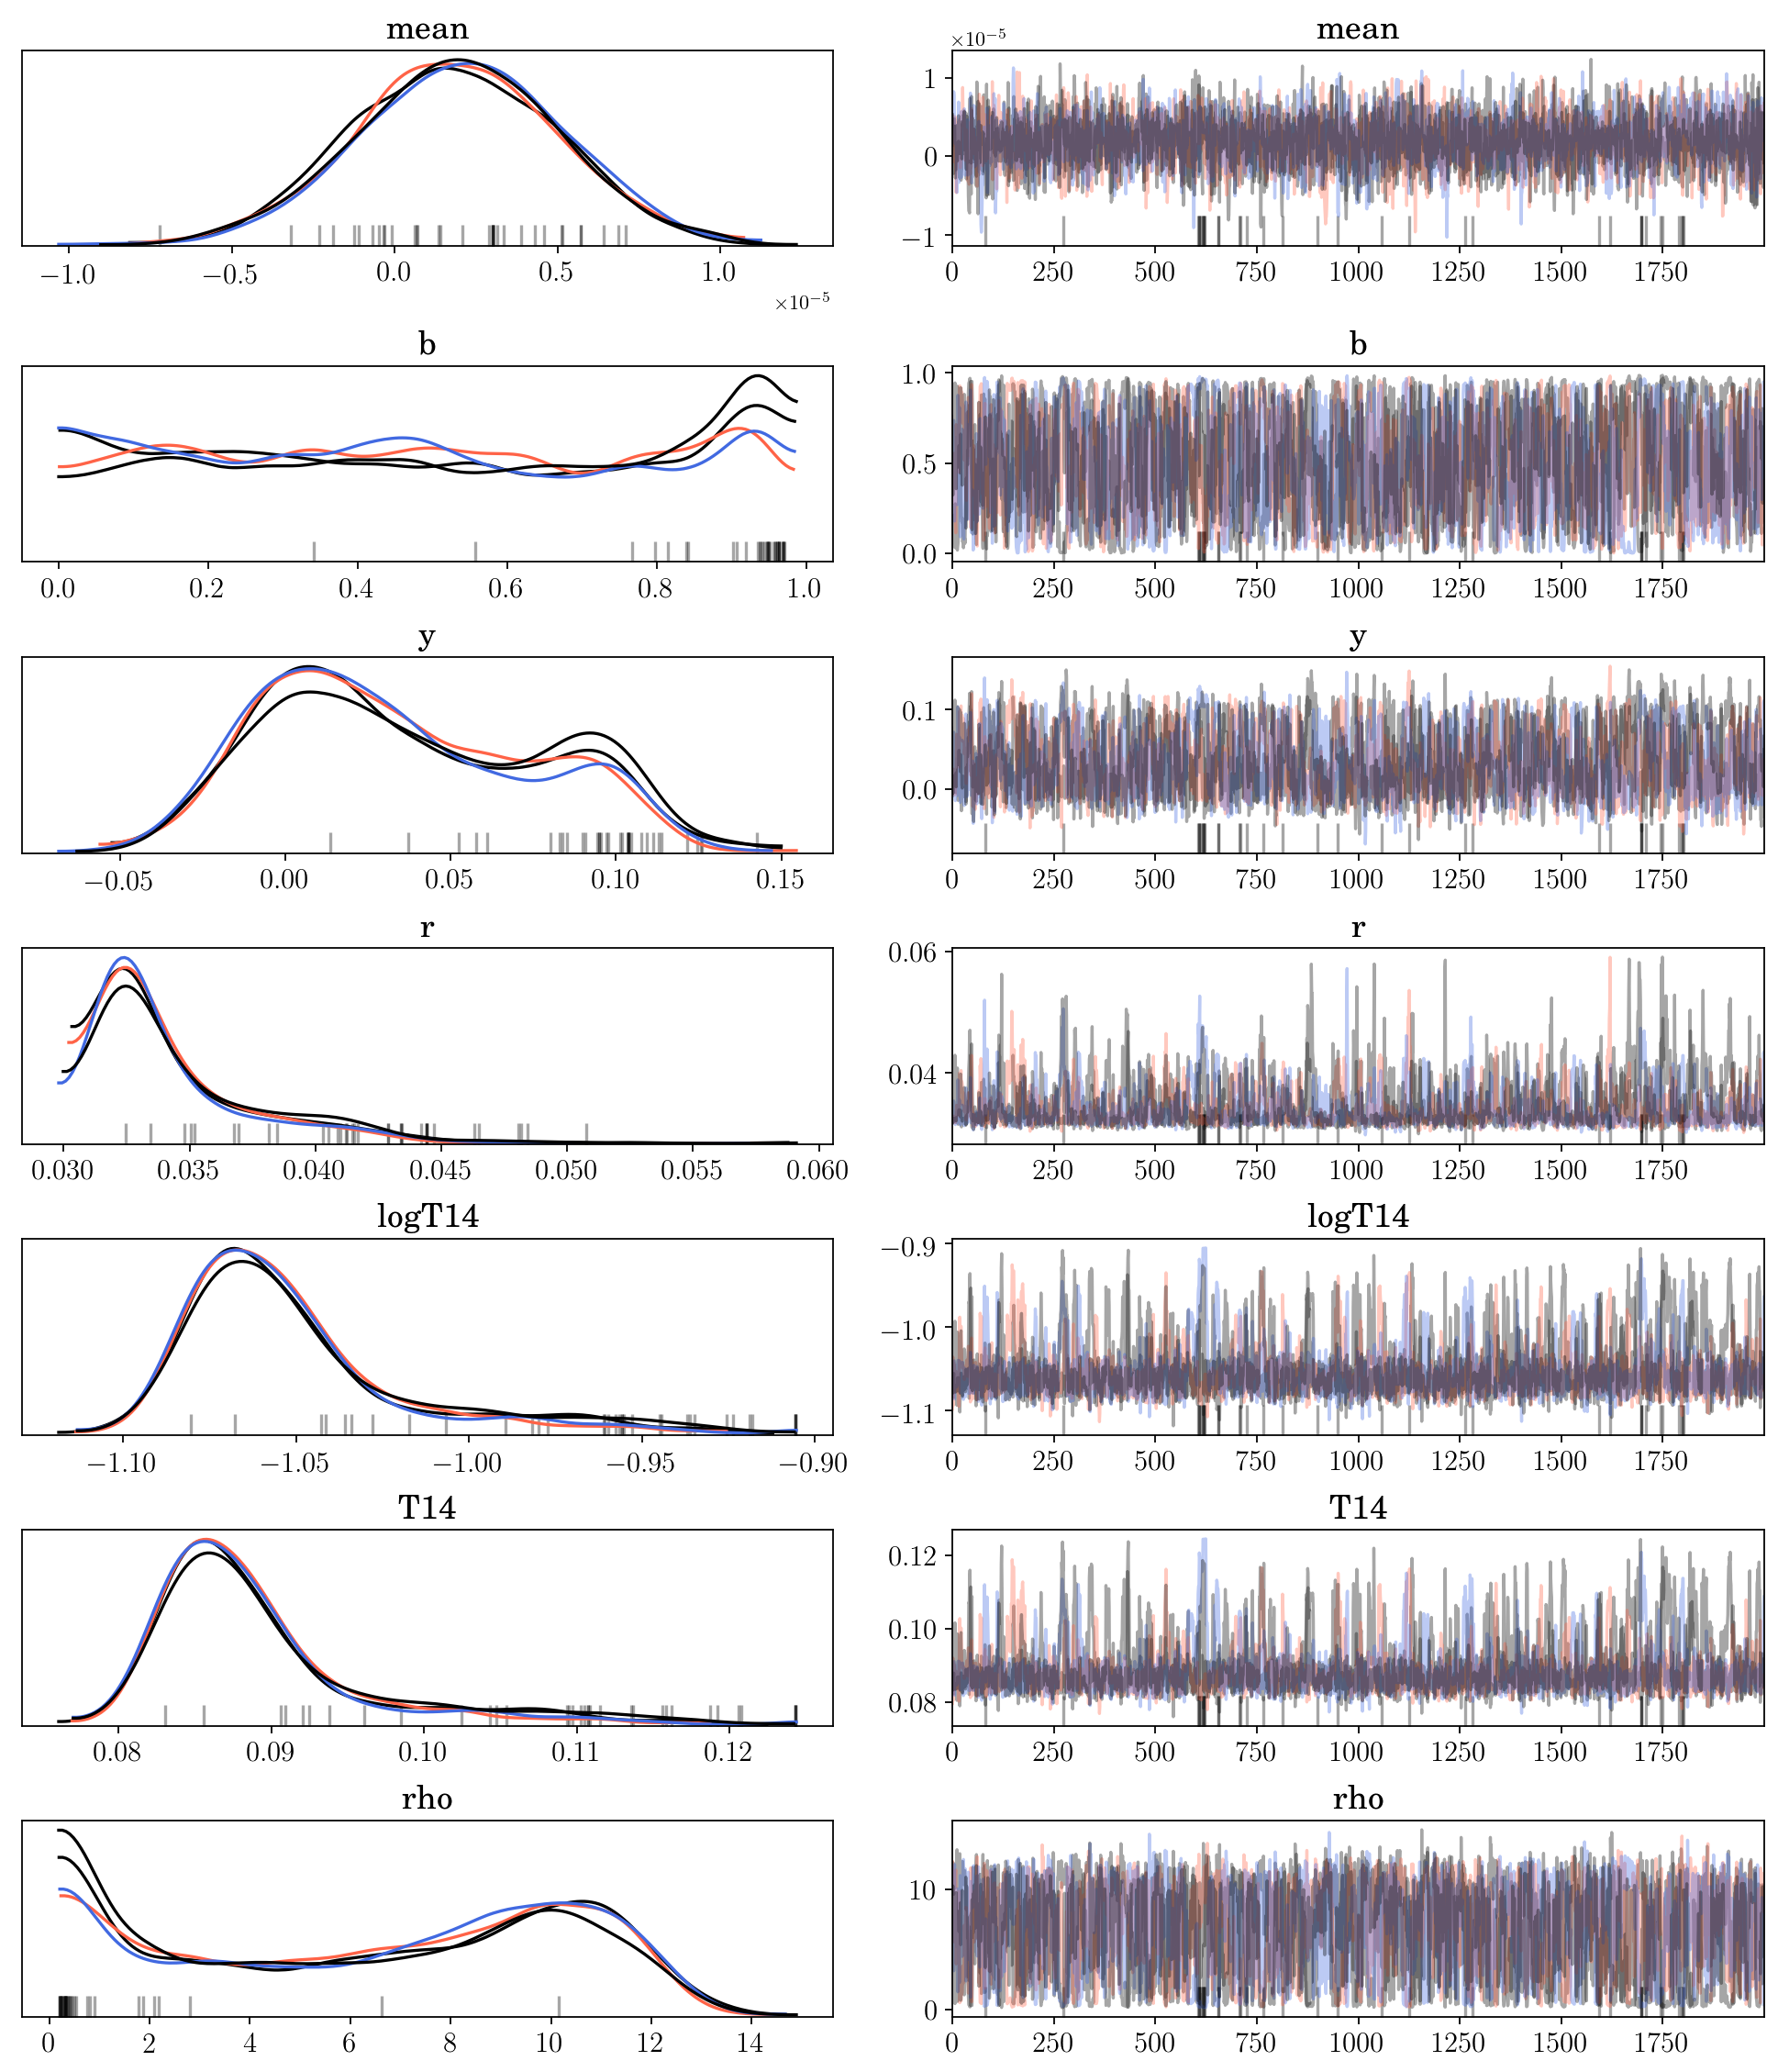

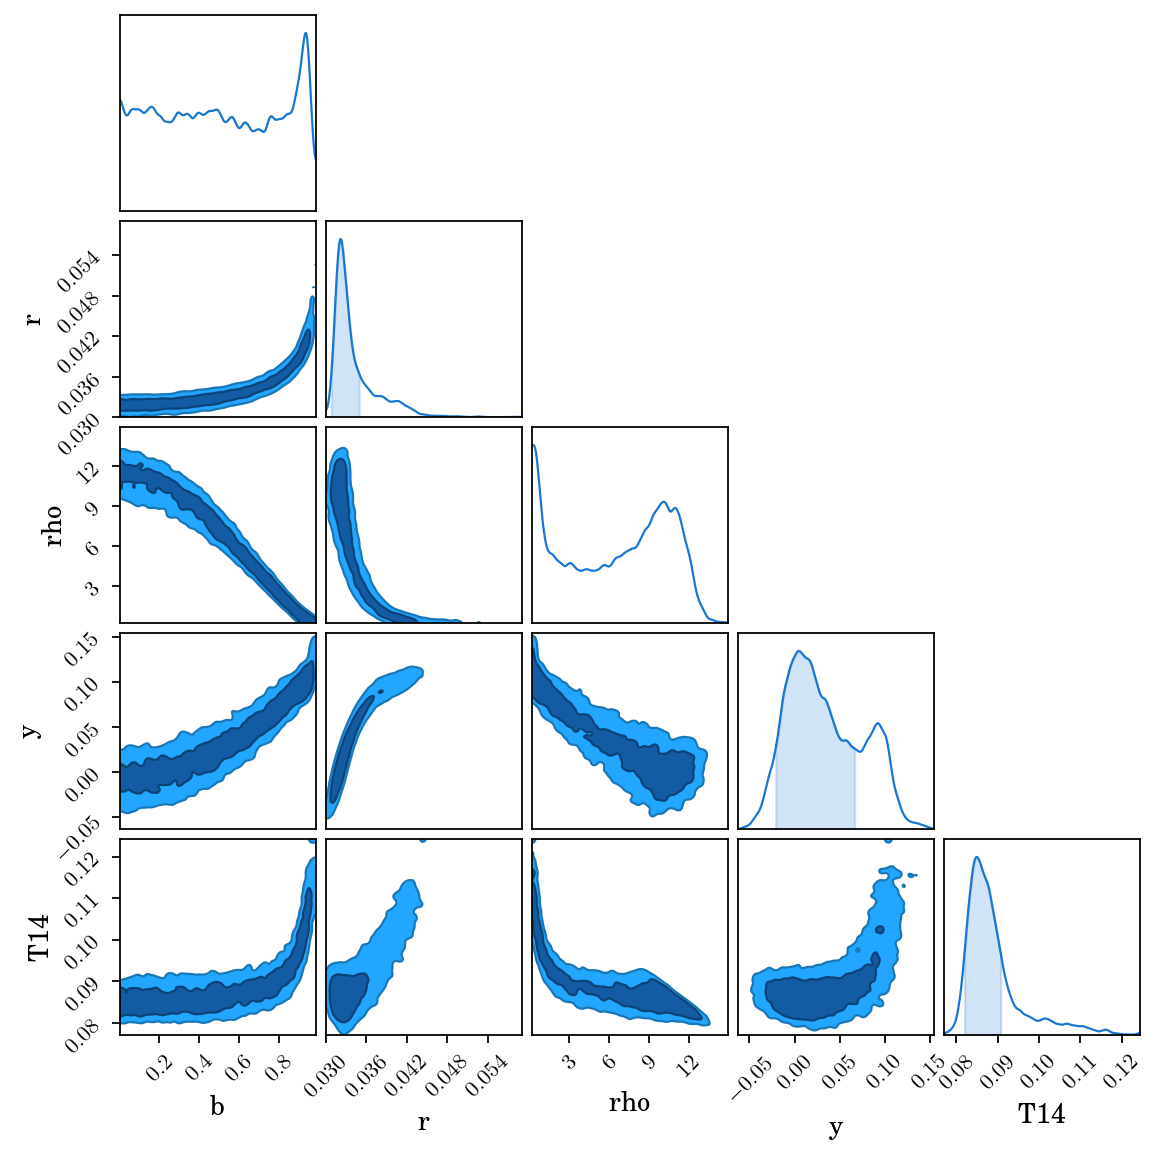

In [18]:
df = pm.trace_to_dataframe(tr_lc)
df.to_csv('chain_notes_param-b-y-logT14_95.csv')
print( pm.summary(tr_lc).round(3) ) 
pm.traceplot(tr_lc)
df = pm.trace_to_dataframe(tr_lc)
varnames='b r rho y T14'.split()
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()